In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM, going beyond k-means

Make some data

In [2]:
from sklearn.datasets.samples_generator import make_blobs

In [3]:
X, Y_true = make_blobs( n_samples = 400, centers =4, cluster_std = 0.60, random_state = 0 )
X = X[ :, ::-1] # flip axis for beter plotting

Plot data with k-means labels

In [4]:
from sklearn.cluster import KMeans

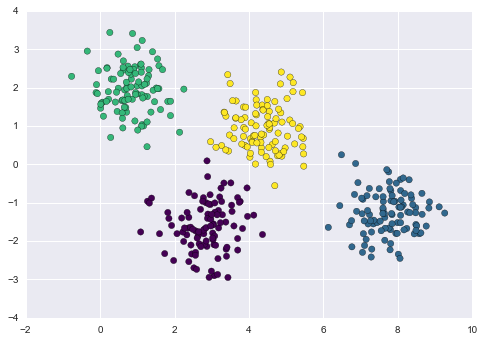

In [6]:
kmeans = KMeans( 4 , random_state = 0 )
labels = kmeans.fit( X ).predict( X )
plt.scatter( X[ :, 0 ], X[ :, 1], c = labels, s =40 , cmap = 'viridis');

Although we have different confidence on each point belonging to its assigned cluster, k-means offers no intrinsic measure of uncertainty.

## Gaussian Mixture Models

A GMM attempts to find a mixture of multidimensional Gaussian probability distribution that best model the data

In [8]:
from sklearn.mixture import GMM

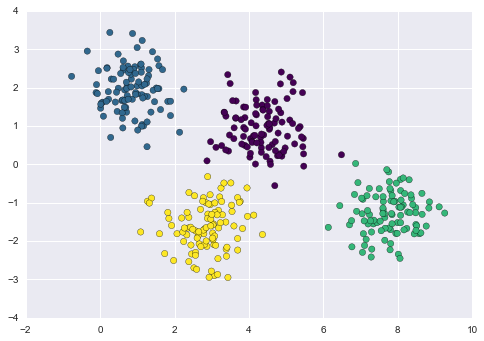

In [9]:
gmm = GMM( n_components = 4 ).fit( X )
labels = gmm.predict( X )
plt.scatter( X[ :,0] , X[:,1], c = labels,  s=40 , cmap = 'viridis' );

But now we can compute the probability of being in each cluster

In [10]:
probs = gmm.predict_proba( X )
print( probs[ :10 ].round(3) )

[[ 0.525  0.     0.475  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.     0.     1.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.992  0.     0.     0.008]
 [ 0.     0.     0.     1.   ]
 [ 0.     1.     0.     0.   ]]


#### Reflect uncertainty in the plot

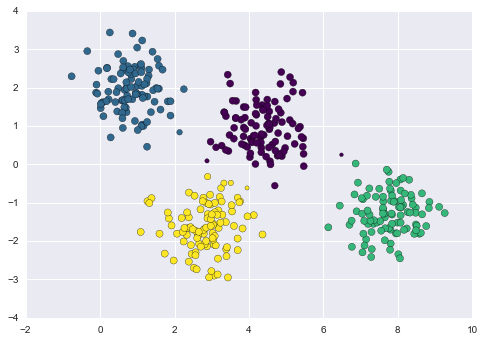

In [12]:
size = 50 * probs.max( axis = 1) **2 # boost differences with the square
plt.scatter( X[:,0] , X[:,1], c = labels, s = size, cmap = 'viridis' );

##### Function to write ellipses

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

We can have a look at our original data and how the model represents it

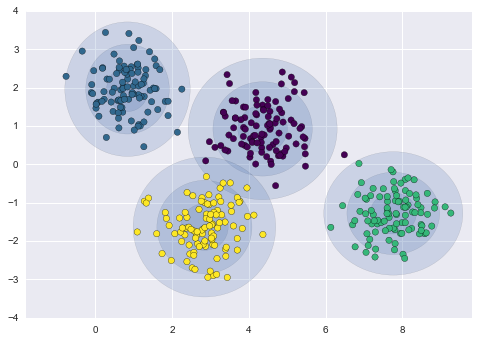

In [14]:
plot_gmm( gmm, X )

But now, if we change the shape of the clusters ...

In [28]:
rng = np.random.RandomState(0)
X_stretched = np.dot(X, rng.randn(2, 2))

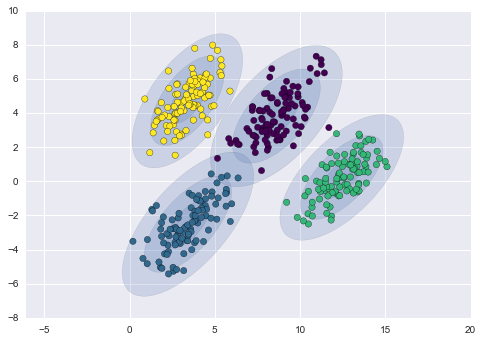

In [30]:
gmm = GMM( n_components=4, covariance_type='full', random_state=10 )
plot_gmm( gmm, X_stretched )

### How many Gaussians?

Since GMM are generative we can evaluate the likelihood of the data given the model via cross-validation. Also we can use analytic criteria such as BIC, AIC, ..

In [32]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

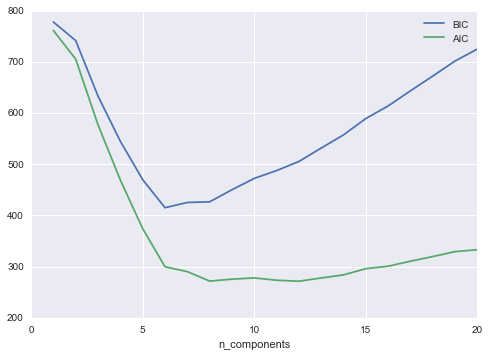

In [34]:
n_components = np.arange( 1, 21 )
models = [ GMM(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components ]
plt.plot( n_components, [m.bic(Xmoon) for m in models ] , label = 'BIC' )
plt.plot( n_components, [m.aic(Xmoon) for m in models ] , label = 'AIC' )
plt.legend( loc = 'best' )
plt.xlabel( 'n_components' );

6 components appear to be the best choice to me.

### GMM for generating new data

Load, see, and compress original data

In [37]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Plot the first 100 of them

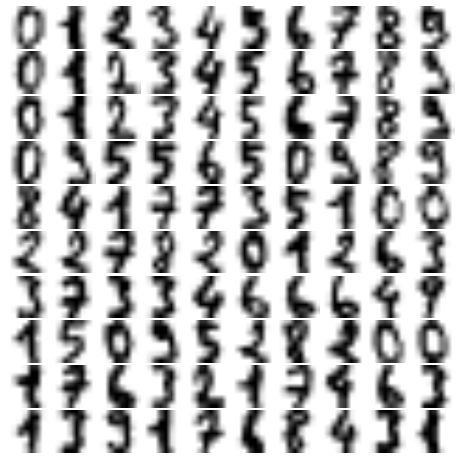

In [38]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We hace 1797 digits in 64 dimensions. Let's reduce the dimensionality with PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA( 0.99, whiten = True )
data = pca.fit_transform( digits.data )
data.shape

(1797, 41)

We are going to use those 41 dimensions to generate more data based on a GMM. First, we need to decide the best number of Gaussians

In [44]:
n_components = np.arange( 50, 210, 10 )
models = [ GMM(n, covariance_type='full', random_state=0 ) for n in n_components ]
aics = [ model.fit(data).aic(data) for model in models ]

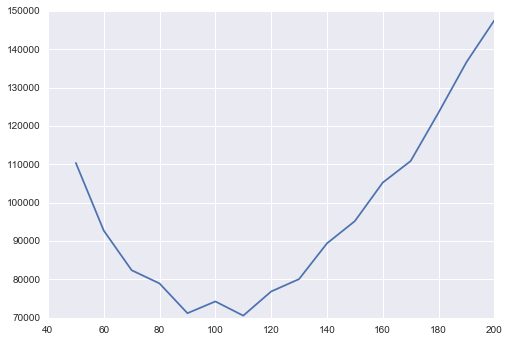

In [45]:
plt.plot( n_components, aics );

In [51]:
gmm = models[6] # for 110 components

In [52]:
print(gmm.converged_)

True


The model has converged

#### Generate data for the model with 100 components in the PCA space of 41 dimensions

In [53]:
data_new = gmm.sample(100, random_state=0)
data_new.shape

(100, 41)

In [54]:
data_new = pca.inverse_transform( data_new )

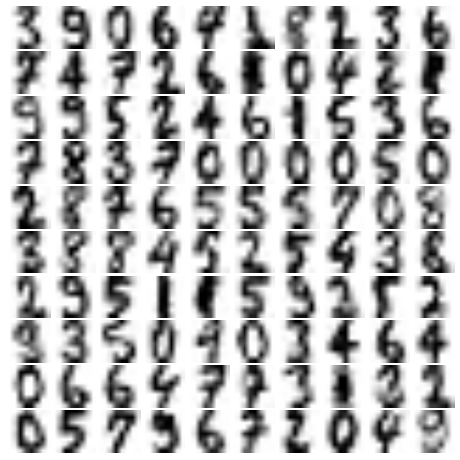

In [55]:
plot_digits( data_new )

These are new digits, generated from the GMM model!